In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/VCB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

       Price    Open    High     Low     Vol. Change %
0     47,765  46,844  47,765  46,690  910.43K    2.81%
1     48,226  47,765  48,379  47,765    1.72M    0.97%
2     48,379  48,226  48,994  47,995    2.01M    0.32%
3     48,149  48,456  48,610  47,535    1.38M   -0.48%
4     48,456  48,149  48,994  48,072    2.42M    0.64%
...      ...     ...     ...     ...      ...      ...
1308  90,200  90,400  90,600  89,700    1.06M    0.00%
1309  90,700  89,800  90,700  89,800    1.35M    0.55%
1310  89,800  90,800  91,000  89,800    1.19M   -0.99%
1311  88,600  89,500  89,700  88,500    2.36M   -1.34%
1312  87,200  88,700  89,000  87,200    3.92M   -1.58%

[1313 rows x 6 columns]


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low     Vol.  Change %
0     47765.0  46844.0  47765.0  46690.0   910430    0.0281
1     48226.0  47765.0  48379.0  47765.0  1720000    0.0097
2     48379.0  48226.0  48994.0  47995.0  2009999    0.0032
3     48149.0  48456.0  48610.0  47535.0  1380000   -0.0048
4     48456.0  48149.0  48994.0  48072.0  2420000    0.0064
...       ...      ...      ...      ...      ...       ...
1308  90200.0  90400.0  90600.0  89700.0  1060000    0.0000
1309  90700.0  89800.0  90700.0  89800.0  1350000    0.0055
1310  89800.0  90800.0  91000.0  89800.0  1190000   -0.0099
1311  88600.0  89500.0  89700.0  88500.0  2360000   -0.0134
1312  87200.0  88700.0  89000.0  87200.0  3920000   -0.0158

[1313 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1313.000000,1313.000000,1313.000000,1313.000000,1.313000e+03,1313.000000
mean,72471.978675,72424.153085,73233.866717,71622.597867,1.361500e+06,0.000628
std,11823.011892,11856.644405,11887.268082,11751.982547,7.560500e+05,0.017210
min,43925.000000,43925.000000,44847.000000,43465.000000,1.804900e+05,-0.149200
25%,63760.000000,63892.000000,64606.000000,63336.000000,8.581200e+05,-0.008400
50%,73238.000000,73316.000000,74167.000000,72387.000000,1.210000e+06,0.000000
75%,80900.000000,80694.000000,81755.000000,79819.000000,1.700000e+06,0.008900
max,97400.000000,98500.000000,100500.000000,97300.000000,8.010000e+06,0.069200


In [5]:
df1=df.reset_index()['Price']
df1

0       47765.0
1       48226.0
2       48379.0
3       48149.0
4       48456.0
         ...   
1308    90200.0
1309    90700.0
1310    89800.0
1311    88600.0
1312    87200.0
Name: Price, Length: 1313, dtype: float64

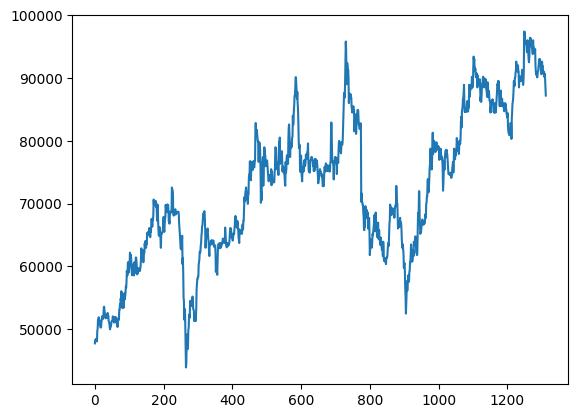

In [6]:
plt.plot(df1)

## LSTM are sentitive to the scale of the data => apply MinMax schaler

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# df1.shape
print(df1)

[[0.07180926]
 [0.08043011]
 [0.08329126]
 ...
 [0.85787751]
 [0.83543712]
 [0.80925666]]


In [9]:
# 4. split the data into train and test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [10]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# c. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
print(X_train)

[[[0.07180926]
  [0.08043011]
  [0.08329126]
  ...
  [0.31306218]
  [0.31164095]
  [0.28291725]]

 [[0.08043011]
  [0.08329126]
  [0.07899018]
  ...
  [0.31164095]
  [0.28291725]
  [0.29439925]]

 [[0.08329126]
  [0.07899018]
  [0.08473118]
  ...
  [0.28291725]
  [0.29439925]
  [0.30588125]]

 ...

 [[0.42158018]
  [0.39783076]
  [0.40258065]
  ...
  [0.57991585]
  [0.60050491]
  [0.6511828 ]]

 [[0.39783076]
  [0.40258065]
  [0.40417017]
  ...
  [0.60050491]
  [0.6511828 ]
  [0.6400935 ]]

 [[0.40258065]
  [0.40417017]
  [0.41683029]
  ...
  [0.6511828 ]
  [0.6400935 ]
  [0.63534362]]]


In [12]:
# # 8. Build LSTM modal

# # Define the model
# model = Sequential()

# # Add a 1D convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# # Add a max pooling layer
# model.add(MaxPooling1D(pool_size=2))

# # Add another 1D convolutional layer
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# # Add a bidirectional LSTM layer
# model.add(Bidirectional(LSTM(100, activation='relu')))

# # Add a dense output layer
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\mikey\OneDrive\Desktop\LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 779ms/step - loss: 0.1482 - val_loss: 0.0683
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0155 - val_loss: 0.0088
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
# 10. Dự báo dữ liệu test
# train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step


In [17]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
# train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [18]:
##Transformback to original form
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)   

Testing RMSE: 1135.6407019500891
Testing MAE: 851.0078125
Testing MAPE: 0.009596120682575583


In [20]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,y_pred))

1135.6407019500891

In [21]:
len(test_data)

263

In [22]:
# x_input = test_data[162:].reshape(1,-1)
# x_input.shape

In [23]:
# temp_input = list(x_input)
# temp_input = temp_input[0].tolist()

In [24]:
# temp_input

In [25]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

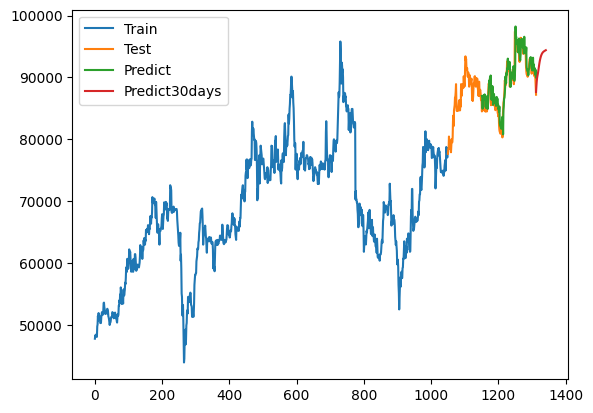

In [26]:
# 15.Vẽ hình dự báo 30 ngày tiếp theo

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [27]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

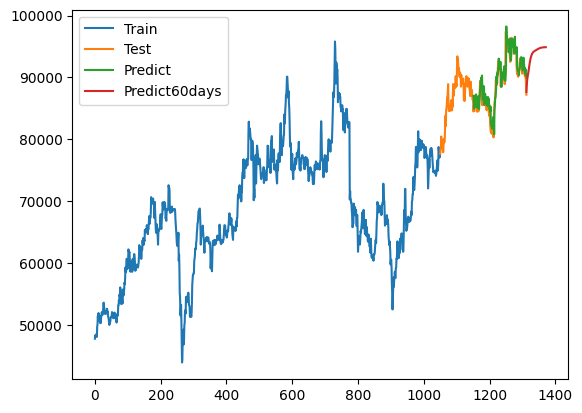

In [28]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_60)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_60))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [29]:
# 12. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

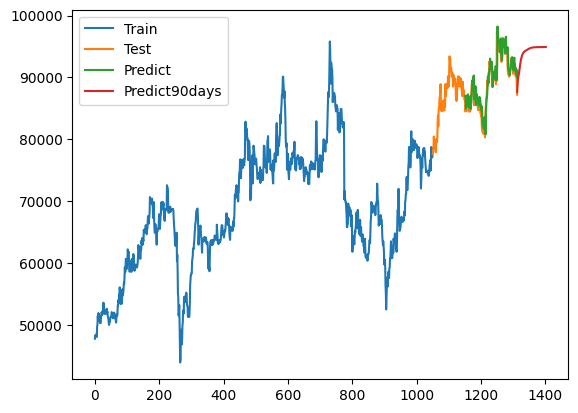

In [30]:
# 15. Vẽ hình dự báo 30 ngày tiếp theo
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(lst_output_90)), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output_90))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()